Github Repo Link: https://github.com/KenMcCarthy24/DTSA_5511_Final

# Introduction

The goal of this project is to use deep learning techniques to build a model that can predict, with high accuracy, whether it will rain on a given day in Seattle, Washington, based on the weather data from the previous day. Seattle is well known for being a rainy city for much of the year but also has more varied weather patterns as well, making it a good place to use for a case study. Traditional meteorological models, while often accurate, rely on large-scale physics simulations of atmospheric conditions, and often need significant computational resources. In contrast, this project explores the feasibility of a smaller, more specialized model focused solely on predicting rainfall in a specific location, in this case Seattle.

If successful, this approach could be a precursor to the development of a large amount of individualized models, each tailored to predict rainfall (or potentially other weather phenomena) in different locations. This would offer a more computationally efficient alternative to the existing large-scale models, potentially benefiting a variety of sectors including agriculture, urban planning, and disaster management. By focusing on the localized nuances of weather patterns, these specialized models could provide more accurate and actionable insights for diverse geographical locations.

# Imports

In [ ]:
import calendar
import json
import os
import shutil
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
from meteostat import Stations, Point, Hourly
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.subplots as sbplt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional, Dense, GRU, LSTM, SimpleRNN
from keras.models import Sequential
from tensorflow.keras import backend as K

# Create Dataset

The first step in this project is to obtain a dataset of historical weather data in Seattle. This will be done through a python library known as `meteostat`, which provides an interface for obtaining hour by hour weather data. Meteostat allows the user to pull down weather data from any latitude and longitude and it will interpolate data from nearby weather stations to predict the weather data at a given point.

In order to remove the uncertainty in that interpolation, this project will try to predict the rainfall at the exact point of a weather station so interpolation isn't necessary. The weather station that will be used is the one at Seattle-Tacoma Airport. The below code finds information about that weather station and, most importantly, gets the World Meteorological Organization (WMO) ID, which is needed to lookup data from that station.

In [ ]:
latitude = 47.458250
longitude = -122.291170

stations = Stations()
stations = stations.nearby(latitude, longitude)
station = stations.fetch(1)
station.head()

Next, the `meteostat` library will be used to get a dataset that consists of hourly weather data. The dataset will start on 1-1-2017 and end on 9-15-2023 (the date at time of writing). Below is a table that explains all of the channels that 'meteostat' provides. This table is sourced directly from the `meteostat` documentation: https://dev.meteostat.net/python/hourly.html#example

| Variable | Description                                   | Data Type  |
|----------|-----------------------------------------------|------------|
| time     | The datetime of the observation               | Datetime64 |
| temp     | The air temperature in °C                     | Float64    |
| dwpt     | The dew point in °C                           | Float64    |
| rhum     | The relative humidity in percent (%)          | Float64    |
| prcp     | The one hour precipitation total in mm        | Float64    |
| snow     | The snow depth in mm                          | Float64    |
| wdir     | The average wind direction in degrees (°)     | Float64    |
| wspd     | The average wind speed in km/h                | Float64    |
| wpgt     | The peak wind gust in km/h                    | Float64    |
| pres     | The average sea-level air pressure in hPa     | Float64    |
| tsun     | The one hour sunshine total in minutes (m)    | Float64    |
| coco     | The weather condition code                    | Float64    |


In [ ]:
start_date = datetime(2017, 1, 1)
end_date = datetime(2023, 9, 15, 23, 59)

weather_data_df = Hourly(station.iloc[0].wmo, start_date, end_date).fetch()
print(f"Weather Dataframe has shape {weather_data_df.shape}")

weather_data_df.head()

# Cleaning and EDA

From the preview of the dataset above, it can be seen that several of the columns have NaN values. NaNs do not work very well with the machine learning approaches that will be used below so it is necessary to know how many Nans there are per column.

In [ ]:
weather_data_df.isna().sum()

The columns of `snow`, `wpgt`, and `tsun` do not have any non-NaN values in this time range so they will be removed. Additionally the columns of `coco` and `wdir` will also be removed. `coco` is a weather condition code and wouldn't be useful for machine learning and `wdir` represents the wind direction, which is unlikely to be a useful feature for predicting rainfall.

Of the remaining columns, only `prcp` and `pres` have NaNs. There are not that many NaN values in `pres`, so linear interpolation will be used to inpute the missing data. As for `prcp`, it will be assumed that a NaN in this column implies there was no rainfall so each NaN will be replaced with a 0. 

In [ ]:
weather_data_df_clean = weather_data_df.drop(["snow", "wpgt", "tsun", "coco", "wdir"], axis=1).fillna(0)
weather_data_df_clean.pres = weather_data_df_clean.pres.interpolate(method="linear")
weather_data_df_clean.head()

In [ ]:
weather_data_df_clean.isna().sum()

Now it can bee seen above that each row in the data has valid numbers. 

Next, histograms will be made for the six weather channels to get an idea of their distribution and check for outliers.

In [ ]:
rows, cols = 2, 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
for idx, col in enumerate(weather_data_df_clean.columns):
    ax = axes[idx // cols, idx % cols]
    ax.hist(weather_data_df_clean[col], bins=100, edgecolor='k', alpha=0.65)
    ax.set_title(col)

plt.tight_layout()
plt.show()

Observations:
* Temperature, Dew Point, Relative Humidity seem to be clean with no significant outliers
* Precipitation, Wind Speed, and Pressure all have significant outliers that need to be investigated

In order to visualize the outliers in Precipitation, Wind Speed, and Pressure, a plot of the time series for each will be made.

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Precipitation Plot
axs[0].plot(weather_data_df_clean.index, weather_data_df_clean.prcp)
axs[0].set_title('Prcp')
axs[0].set_ylabel('Precipitation (mm)')

# Wind Speed Plot
axs[1].plot(weather_data_df_clean.index, weather_data_df_clean.wspd)
axs[1].set_title('Wspd')
axs[1].set_ylabel('Wind Speed (km/h)')

# Pressure Plot
axs[2].plot(weather_data_df_clean.index, weather_data_df_clean.pres)
axs[2].set_title('Pres')
axs[2].set_ylabel('Pressure (hPa)')

plt.tight_layout()
plt.show()


Observations:
* The outliers in precipitation are still reasonable values for rainfall, so they will not be removed.
* There are only a few points where the windspeed goes to almost 100. These are likely not real measurements and will be filtered out
* During 2017 and 2018 the pressure often dropped to zero. These cannot be physical as that would mean the atmosphere disappeared and it appears this weather stations stops reporting these zero pressures after mid-2018. These zero pressure values need to be removed 

Based on the above observations, the outliers in wind speed and pressure will be filtered out and replaced with interpolated values 

In [ ]:
# Replace winds speeds above 80 and pressures of 0 with NaN
weather_data_df_clean.loc[weather_data_df_clean['wspd'] > 80, 'wspd'] = np.nan
weather_data_df_clean.loc[weather_data_df_clean['pres'] == 0, 'pres'] = np.nan

In [ ]:
# Interpolate nans again
weather_data_df_clean.wspd = weather_data_df_clean.wspd.interpolate(method="linear")
weather_data_df_clean.pres = weather_data_df_clean.pres.interpolate(method="linear")

With those outliers removed the histograms of all channels will be visualized again

In [ ]:
rows, cols = 2, 3

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
for idx, col in enumerate(weather_data_df_clean.columns):
    ax = axes[idx // cols, idx % cols]
    ax.hist(weather_data_df_clean[col], bins=100, edgecolor='k', alpha=0.65)
    ax.set_title(col)

plt.tight_layout()
plt.show()

Now the distributions of all channels are much more clean and contain only believable values.

As a final EDA step, a correlation matrix will be made in order to visualize any collinearities between columns.

In [ ]:
corr_matrix = weather_data_df_clean.corr()
plt.matshow(corr_matrix)
plt.xticks(range(weather_data_df_clean.shape[1]), weather_data_df_clean.columns, fontsize=14, rotation=45)
plt.yticks(range(weather_data_df_clean.shape[1]), weather_data_df_clean.columns, fontsize=14)

for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha='center', va='center', fontsize=12)

cb = plt.colorbar()
plt.show()

Based on this correlation matrix, it seems that all columns are independent of each other with the exception of `temp` and `dwpt`, which have a positive correlation and `rhum` and `temp`, which have a negative correlation. These correlations makes some sense as the dew point is itself a temperature below which dew will start to form so it is likely to be correlated with ambient temperature and relative humidity is the amount of water vapor the atmosphere can hold at a given ambient temperature, so it is also likely to be correlated to temperature.

The deep learning models that will be used below should be resilient against collinearities within the training data, but is is still worthwhile to note these collinearities as a possible future avenue for model improvement.

# Create Data Arrays

The goal of this project is to predict whether it will rain on a given day based on the weather data from the previous day. Currently, the dataset consists of hourly weather measurements across six different weather data channels, which is not the ideal format for achieving the project's goals. To address this, the input features need to be reshaped into individual days, resulting in a (n_days, 24, n_channels) array that will serve as the input features for the machine learning models. All weather data columns will be utilized, with the exception of `prcp`, which will be used for the target. 

In [ ]:
n_days = int(weather_data_df_clean.shape[0]/24)
feature_columns = ["temp", "dwpt", "rhum", "wspd", "pres"]

X = weather_data_df_clean[feature_columns].values.reshape((n_days, 24, len(feature_columns)))
X.shape

The `prcp` column will be used to create the target vector. For each day in the dataset, the `prcp` data is summed up to determine the total daily precipitation. This value is then converted into a binary format, where 0 means no rain on that day, and 1 indicates rainfall. Finally, the binary rainy days vector is shifted by one position to represent whether it will rain the next day.

Note: For simplicity's sake this project will refer to all days with precipitation as rainy days. However the precipitation could, in real life, have taken on many different forms such as rain, snow, sleet, or hail. 

In [ ]:
precipitation_data = weather_data_df_clean["prcp"].values.reshape((n_days, 24))
total_daily_precipitation = np.sum(precipitation_data, axis=1)
rainy_days_binary = (total_daily_precipitation > 0).astype(int)
shifted_rainy_days_binary = np.roll(rainy_days_binary, -1)
y = shifted_rainy_days_binary
y.shape

Additionally, an array will be created that represents what day each time series represents, stored as a datetime object.

In [ ]:
days = np.unique(weather_data_df_clean.index.date)
days.shape

Due to the shifting of the target variable data by one index using `np.roll()`, the last day in the dataset no longer has a meaningful label. This is because it would imply predicting rainfall on the first day of the dataset using data from five years later, which is not logical. Therefore, this day is excluded from the dataset.

In [ ]:
X = X[:-1]
y = y[:-1]
days = days[:-1]

Next, a plot will be made to visualize the distribution of rainy days for each month of the year.

In [ ]:
months = np.array([calendar.month_name[day.month] for day in days], dtype=object)
rainy_day_idxs = np.where(y == np.ones(len(y)))[0]
rainy_day_months = months[rainy_day_idxs]

fig = go.Figure()
fig.add_trace(go.Histogram(x=rainy_day_months))

fig.update_yaxes(title_text="Rainy Day Count")
fig.update_xaxes(
    title_text="Month",
    type='category',
    categoryorder='array',
    categoryarray=['January', 'February', 'March', 'April', 'May', 'June', 'July',
                   'August', 'September', 'October', 'November', 'December']
)

fig.show()

From this plot it can be seen that the winter and spring months have the most precipitation while the summer months have the least. 

Finally, a plot will be made to visualize the distribution of labels in the dataset to check for any imbalance.

In [ ]:
_, counts = np.unique(y, return_counts=True)
plt.pie(counts/np.sum(counts), labels=["Won't Rain", "Will Rain"], autopct='%1.1f%%')
plt.show()

The data is slightly imbalanced, with 58% of the days in the dataset having no rain the next day and the remaining 42% having rain the next day. This imbalance, however, is not large enough to consider using any data balancing techniques.

# Train/Validate/Test Split

Next the dataset created above will be split into train, validate, and test data. The test data will be all days that are in the year 2023. This means that all models will be trained on what amounts to historical data and used to predict future rainfall on a day by day basis. Remaining data from 2017-2022 will be randomly split 80/20 into a Train and Validation set. 

In [ ]:
test_indices = np.where(np.array([days[i].year for i in range(len(days))]) == 2023)[0]
X_test = X[test_indices]
y_test = y[test_indices]
days_test = days[test_indices]

In [ ]:
remaining_indices = np.array(range(len(days[:-X_test.shape[0]])))
train_indices, validate_indices = train_test_split(remaining_indices, test_size=0.2, random_state=42)

In [ ]:
X_train = X[train_indices]
y_train = y[train_indices]
days_train = days[train_indices]

X_validate = X[validate_indices]
y_validate = y[validate_indices]
days_validate = days[validate_indices]

In [ ]:
print(f"Training Data shape: {X_train.shape}")
print(f"Validation Data shape: {X_validate.shape}")
print(f"Testing Data shape: {X_test.shape}")

# Normalize Data

All of the data channels that make up the input data have vastly different magnitudes of values. For example the values in the `dwpt` channels are single or double digit numbers while values in the `pres` column are two orders of magnitude higher. This difference in data magnitude is not ideal for machine learning so the data will be standardized in order to make all data have 0 mean and unit standard deviation. This standardization will be fit on the training data and applied to the training and validation sets in order to prevent a data leak. 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2])))

In [ ]:
X_train_norm = scaler.transform(X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2]))).reshape(X_train.shape)
X_validate_norm = scaler.transform(X_validate.reshape((X_validate.shape[0]*X_validate.shape[1], X_validate.shape[2]))).reshape(X_validate.shape)
X_test_norm = scaler.transform(X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))).reshape(X_test.shape)

# Model Trainer Class

Next, in order to speed up iteration on the model and reduce repeated code, the `ModelTrainer` class will be defined that contains methods for fitting and evaluating models. The methods in the class are:
* `fit()`: Trains the model given the given training and validation data for a given number of epochs and with a given batch size. The final model as well as the training history is saved to file so it can be easily loaded in later without re-training the model, which happens if `load_from_file` is True. If `show_results` is true the results of the training are shown. 
* `plot_history()`: Creates three plots that plot the train and validation loss, accuracy, and F1 score over the training epochs.
* `print_best_model()`: Prints a summary of the best performing model, defined as the model with the lowest validation loss. 
* `predict()`: Given an input matrix X, predicts the target label
* `evaluate()`: Given an input matrix X and a target vector y, calculates the accuracy and F1 score of the model.

One callbacks will be used for model training:
* `ModelCheckpoint()`: This outputs the best model to file during training

In [ ]:
class ModelTrainer():
    def __init__(self, model, folder_path, name):
        self.model = model
        self.folder_path = folder_path
        self.name = name
        self.history = None
        
    def fit(self, X_train, y_train, X_validate, y_validate, epochs=100, batch_size=32, load_from_file=False, show_results=True):
        # Define model filepaths
        model_file = os.path.join(self.folder_path, "model.ckpt")
        history_file = os.path.join(self.folder_path, "history.json")
        
        if load_from_file and os.path.isfile(history_file):
            # Load existing model from file
            self.model.load_weights(model_file).expect_partial()
            with open(history_file) as f:
                self.history = json.load(f)
                
        else:
            # Make output directory if it doesn't exist and delete everything in it
            os.makedirs(self.folder_path, exist_ok=True)
            shutil.rmtree(self.folder_path)

            # Define callbacks
            model_checkpoint = ModelCheckpoint(model_file, monitor="val_loss", save_weights_only=True, save_best_only=True, verbose=0)

            # Train model
            self.history = self.model.fit(X_train, y_train, validation_data=[X_validate, y_validate], epochs=epochs, batch_size=batch_size,
                                    callbacks=[model_checkpoint], verbose=0).history

            # Write trained model history to file
            with open(history_file, "w+") as f:
                json.dump(self.history, f)
                
            # Restore best model weights from file
            self.model.load_weights(model_file).expect_partial()
              
        if show_results:
            self.plot_history()
            self.print_best_model()
            

    def plot_history(self):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        epochs = list(range(1, len(self.history["loss"])+1))

        # Plotting Loss
        axes[0].plot(epochs, self.history["loss"], label='Training Loss')
        axes[0].plot(epochs, self.history["val_loss"], label='Validation Loss')
        axes[0].set_title('Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        # Plotting Accuracy
        axes[1].plot(epochs, self.history["accuracy"], label='Training Accuracy')
        axes[1].plot(epochs, self.history["val_accuracy"], label='Validation Accuracy')
        axes[1].set_title('Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        # Plotting custom_f1_score
        axes[2].plot(epochs, self.history["custom_f1_score"], label='Training F1 Score')
        axes[2].plot(epochs, self.history["val_custom_f1_score"], label='Validation F1 Score')
        axes[2].set_title('F1 Score')
        axes[2].set_xlabel('Epochs')
        axes[2].set_ylabel('F1 Score')
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        
    def print_best_model(self):
        best_idx = np.argmin(self.history["val_loss"])
        print(f"Best Epoch: {best_idx + 1}")
        print(f"Best Validation Loss: {self.history['val_loss'][best_idx]}")
        print(f"Best Accuracy: {self.history['accuracy'][best_idx]}")
        print(f"Best F1 Score: {self.history['val_custom_f1_score'][best_idx]}")
        
    def predict(self, X):
        return np.round(self.model.predict(X, verbose=0)).astype(int).flatten()
        
    def evaluate(self, X, y):
        y_hat = self.predict(X)
        acc = accuracy_score(y, y_hat)
        f1 = f1_score(y, y_hat)        
        return acc, f1
        

Also an implementation of the F1 score to be used as a metric for evaluation of models needs to be defined. This implementation was sourced from: https://saturncloud.io/blog/custom-f1score-metric-in-tensorflow/

In [ ]:
def custom_f1_score(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

# Model Ensemble Class

It is expected that each model will have some amount of variance in how accurate its predictions are due to randomness in the training process causing the optimization to find different minima within the loss function space. Therefore, for each model, not just one model will be trained, but several. This way, the variance in model accuracy can be visualized to better understand how well a model architecture does on average, rather than just for one particular random optimization. Additionally, it will also be investigated if allowing multiple identical architecture but separately trained models to vote on if it will rain or not performs better than the individual models.

To assist with this the `ModelEnsemble` class will be defined that stores multiple trained models and has methods for evaluating them all at once. The methods in this class are:
* `fit_models()`: A class method that trains a specified number of models using a provided model function and data, initializing and fitting each ModelTrainer instance. It can optionally load models from file and display results, returning a ModelEnsemble instance containing the trained models.

* `ensemble_predict()`: Aggregates predictions from all models in the ensemble for a given input matrix X and returns the majority vote as the ensemble's prediction, effectively implementing a form of model averaging to reduce variance and potentially improve accuracy.

* `evaluate_models()`: Iterates through each model in the ensemble and evaluates their individual performance using the provided input matrix X and target vector y, returning a list of accuracies for each model.

* `evaluate_ensemble()`: Evaluates the overall performance of the ensemble by comparing the ensemble's aggregated predictions to the target vector y, calculating the accuracy of the ensemble model.

* `get_violin_plot_traces()`: Generates violin plot traces for visualizing the distribution of accuracies of individual models in the ensemble, along with a scatter point representing the ensemble's overall accuracy, facilitating the comparison and analysis of model variance and ensemble performance.

In [ ]:
class ModelEnsemble:
    def __init__(self, N, name, model_trainers, folder_path):
        self.N = N
        self.name = name
        self.model_trainers = model_trainers
        self.folder_path = folder_path
        
    @classmethod
    def fit_models(cls, N_models, ensemble_name, model_function, folder_path,
                   X_train, y_train, X_validate, y_validate,
                   load_from_file=False, show_results=True):
        
        model_trainers = []
        for i in range(N_models):
            model_trainer = ModelTrainer(model_function(), os.path.join(folder_path, ensemble_name, str(i)), f"{ensemble_name}{i}")
            model_trainer.fit(X_train, y_train, X_validate, y_validate, epochs=150, batch_size=512, load_from_file=load_from_file, show_results=show_results)
            
            model_trainers.append(model_trainer)
            
        return cls(N_models, ensemble_name, model_trainers, folder_path)
    
    def ensemble_predict(self, X):
        ensemble_predictions = np.empty((self.N, len(X)))
        for i in range(len(self.model_trainers)):
            ensemble_predictions[i] = self.model_trainers[i].predict(X)

        return (np.mean(ensemble_predictions, axis=0) > 0.5).astype(int)
    
    def evaluate_models(self, X, y):
        accuracies = []
        for model_trainer in self.model_trainers:
            acc, _ = model_trainer.evaluate(X, y)
            accuracies.append(acc)
        
        return accuracies
    
    def evaluate_ensemble(self, X, y):
        y_hat_ensemble = self.ensemble_predict(X)
        acc = accuracy_score(y, y_hat_ensemble)
        return acc
    
    def get_violin_plot_traces(self, X, y):
        model_accuracies = self.evaluate_models(X, y)
        ensemble_accuracy = self.evaluate_ensemble(X, y)
        
        traces = [
            go.Violin(y=model_accuracies, pointpos=0, points="all", meanline_visible=True, name=self.name, legendgroup=self.name),
            go.Scatter(x=[self.name], y=[ensemble_accuracy], marker=dict(color="black", size=10), showlegend=False, legendgroup=self.name)
        ]
        
        return traces
        

# Recurrant Neural Networks

Now that the training, validation, and testing data along with the above helper classes have been defined, an ensemble of models can now be fit to the training data to try and predict if it will rain in Seattle on a given day. At its core, this problem is a binary classification problem that is trying to predict a boolean label for a set of multi-channel time series data. The sequential nature of time series data means that the best choice for a neural network architecture to use for this problem is likely to be a Recurrent Neural Network (RNN). Below is a diagram of a basic RNN architecture.

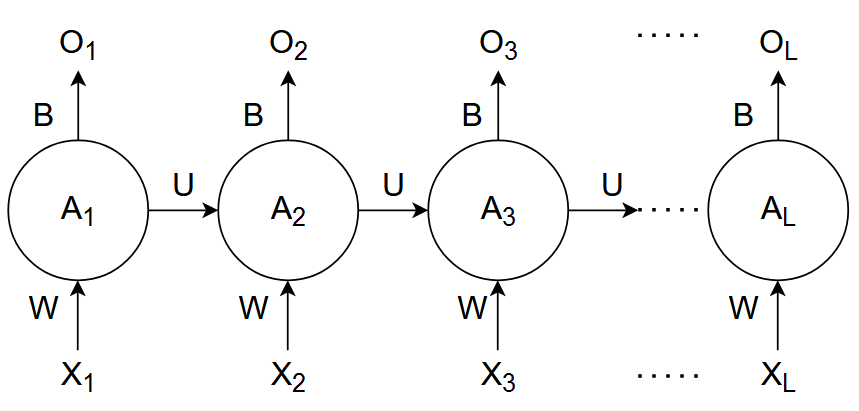

An RNN layer takes as input some input matrix $X = [\vec{x_1}, \vec{x_2}, \vec{x_3}, \ldots, \vec{x_L}]$, where each vector $\vec{x_i}$ represents multiple channels of data at a given timestep and $L$ is the total number of time steps. For this project, $\vec{x_i}$ is the weather data for a given hour and $L=24$, the number of hours in a day. The activation vector $\vec{A_i}$, is the hidden state of the RNN, and stores the information learned from the sequence at the current timestamp. It is calculated as $\vec{A_i} = g(W\vec{x_i} + U\vec{A}_{i-1})$, where $W$ and $U$ are a pair of learnable weight matrices and $g$ is some activation function, like tanh. The size of $\vec{A_i}$ is known as the number of hidden units in the RNN, and is a tunable hyperparameter. By computing $\vec{A_i}$ based on not only the current $\vec{x_i}$ but also the previous activation $\vec{A}_{i-1}$, the RNN can maintain and utilize contextual information from all previous timesteps in a sequence along with the current timestep. Finally, the output $\vec{O_i}$ is computed as $\vec{O_i} = B\vec{A_i}$, where $B$ is another set of learnable weights that transforms the hidden state to the output. The final output of the RNN is the final output vector $\vec{O_L}$. 

# First Simple Model

The first model that will be defined to try and solve this problem will have the following architecture:
* A simple RNN layer with 8 hidden units
* A dense layer with a sigmoid activation function to transform the output of the RNN to a single number that represents the probability that it will rain given the input data
* As this is a binary classification problem, binary crossentropy will beused as a loss function
* Adaptive Moment Estimation (ADAM) will be used as an optimizer
* Model will be trained for 150 epochs with a batch size of 512

An ensemble of 20 of these models will be trained:

In [ ]:
def make_simple_rnn(units):
    """Returns a function that generates simple RNN models with the provided number of hidden units"""
    def get_model():
        model = Sequential()
        model.add(SimpleRNN(units, input_shape=(24, 5)))
        model.add(Dense(1, activation='sigmoid'))
        model.build(input_shape=(None, 24, 7))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", custom_f1_score])
        return model
    return get_model

In [ ]:
simpleRNN8 = ModelEnsemble.fit_models(20, "SimpleRNN8", make_simple_rnn(8), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

Glancing at the optimization plots for these models shows that a lot of the time the model does not optimize or the optimization quickly converges to a solution where the training accuracy is around 0.58 and the F1 score is 0. This represents the trivial solution where the model simply always predicts that it is not going to rain, which is the majority label class. While it is good that the model can find this solution, it is not very interesting. Luckily a few of the models find even better solutions, meaning that the model is able to pick up some patterns in the data to predict if it is going to rain or not. 

Next a violin plot will be made to visualize the distribution of the validation accuracy for all 20 models trained. A black dot will also be placed on the violin plot which represents the "Ensemble Accuracy", which is the accuracy if each model did a simple majority vote for if it is going to rain or not. 

In [ ]:
model_comparison_plot = go.Figure()
model_comparison_plot.update_yaxes(title_text="Validation Accuracy")
model_comparison_plot.add_traces(simpleRNN8.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.show()

Observations:
* This distribution is significantly bimodal
* 15 out of the 20 models found the trivial solution where the majority class was always predicted
* The remaining 5 models managed to optimize to better solutions, the best of which has a validation accuracy of 0.765.
* The ensemble as a whole voted to always predict all labels as 0

# Tune Number of Hidden Units

While the above model did manage to find a solution better than the trivial one in some cases, the majority of the time it failed to optimize to a worthwhile solution, meaning that the model was likely not complex enough to optimize consistently to a non-trivial solution. In order to help the model to consistently find the non-trivial solutions, the hyperparameter for the number of hidden units in the RNN layer of the model will be tuned. This will allow the RNN to store more features in its hidden state. 

Several model ensembles will now be created with different numbers of hidden units from 16 up to 512 (increasing by powers of 2). The distributions of validation accuracy for each ensemble will be added to the violin plot above in order to create a visual comparison of each model architecture's validation accuracy distribution. 

In [ ]:
simpleRNN16 = ModelEnsemble.fit_models(20, "SimpleRNN16", make_simple_rnn(16), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
simpleRNN32 = ModelEnsemble.fit_models(20, "SimpleRNN32", make_simple_rnn(32), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
simpleRNN64 = ModelEnsemble.fit_models(20, "SimpleRNN64", make_simple_rnn(64), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
simpleRNN128 = ModelEnsemble.fit_models(20, "SimpleRNN128", make_simple_rnn(128), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
simpleRNN256 = ModelEnsemble.fit_models(20, "SimpleRNN256", make_simple_rnn(256), "./ensembles",
                                       X_train, y_train, X_validate, y_validate,
                                       load_from_file=True, show_results=True)

In [ ]:
simpleRNN512 = ModelEnsemble.fit_models(20, "SimpleRNN512", make_simple_rnn(512), "./ensembles",
                                       X_train, y_train, X_validate, y_validate,
                                       load_from_file=True, show_results=True)

In [ ]:
model_comparison_plot.add_traces(simpleRNN16.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.add_traces(simpleRNN32.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.add_traces(simpleRNN64.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.add_traces(simpleRNN128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.add_traces(simpleRNN256.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.add_traces(simpleRNN512.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot.show()

Observations:
* 16 hidden units causes more of the models in the ensemble to optimize to non-trivial solutions, but the majority are still finding the trivial solution.
* 32 hidden units makes it so that the majority of models are optimizing to the non-trivial solutions, but some are still finding the trivial solution. 
* 64 hidden units is very similar to 32 hidden units but has a slightly higher mean (dotted line) meaning there are slightly more models that optimized to non-trivial solutions
* 128 hidden units shows a vast improvement over previous model architectures. All models optimized non-trivial solution. However, the best performing models are worse than some of the best performing models with fewer hidden units
* 256 hidden units is very similar to 128 hidden units, but the mean accuracy is a bit lower and the ensemble prediction accuracy is also a bit lower. 
* 512 is again similar to 128 and 256, but the mean is again slightly lower than 256 and the ensemble prediction is lower than the mean.

Based on all these observations, 128 hidden units seems to be the best value. Although it does not provide the best maximum performance, it provides the most consistent performance, having a very low variance in validation accuracy as well as the highest mean and ensemble performance of all the ensembles trained.

# Try Different RNN Types

A major issue with the Simple RNN architectures used in all the models above is that they suffer from the vanishing/exploding gradient problem during backpropagation. This means that the gradients of the loss function can become vanishingly small or explode to huge numbers, hindering the optimization from finding the optimal parameters. This means that Simple RNNs often possess a limited short-term memory and struggle to capture long-term dependencies in the data. Several more sophisticated RNN variants exist, designed to address this gradient problem. The most common of these are the Long Short-Term Memory (LSTM) and the Gated Recurrent Unit (GRU), both of which employ specific gating mechanisms to manage long-term dependencies better.

For this problem, given that there are only 24 timesteps per example, it's possible that the data sequence is short enough that such complex architectures might not be necessary. However, it is still worth exploring these other architectures. Therefore, two more ensembles will be trained next, one that is an LSTM with 128 hidden units and the other that is a GRU with 128 hidden units. The distribution of validation accuracies within these ensembles should give some clarity as to what flavor of RNN model is best for this problem.

In [ ]:
def make_lstm(units):
    """Returns a function that generates LSTM models with the provided number of hidden units"""
    def get_model():
        model = Sequential()
        model.add(LSTM(units, input_shape=(24, 5)))
        model.add(Dense(1, activation='sigmoid'))
        model.build(input_shape=(None, 24, 7))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", custom_f1_score])
        return model
    return get_model

def make_gru(units):
    """Returns a function that generates GRU models with the provided number of hidden units"""
    def get_model():
        model = Sequential()
        model.add(GRU(units, input_shape=(24, 5)))
        model.add(Dense(1, activation='sigmoid'))
        model.build(input_shape=(None, 24, 7))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", custom_f1_score])
        return model
    return get_model

In [ ]:
LSTM128 = ModelEnsemble.fit_models(20, "LSTM128", make_lstm(128), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
GRU128 = ModelEnsemble.fit_models(20, "GRU128", make_gru(128), "./ensembles",
                                      X_train, y_train, X_validate, y_validate,
                                      load_from_file=True, show_results=True)

In [ ]:
model_comparison_plot2 = go.Figure()
model_comparison_plot2.update_yaxes(title_text="Validation Accuracy")
model_comparison_plot2.add_traces(simpleRNN128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot2.add_traces(LSTM128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot2.add_traces(GRU128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot2.show()

Observations
* Compared to the Simple RNN, the LSTM has a higher mean accuracy and a slightly lower variance in accuracies. The ensemble prediction accuracy is also just as good as the best model's accuracy.
* The GRU has a much higher variance in model accuracy and a lower mean than both the simple RNN and LSTM. ALso one model failed to find the non-trivial solution, which wasn't an issue for the other two model types.

Based on these observations, while the Simple RNN and LSTM are very similar, the LSTM has slightly better performance. 

# Try Adding an Additional Dense Layer

Another avenue for potentially improving model performance is to make the model deeper. There are many ways this could be done but the way that will be explored here is the addition of an additional dense layer with a tunable number of units. The addition of this layer could potentially help in the classification of the features found by the RNN. Several model ensembles with an additional dense layer will be trained, ranging from 8 to 256 hidden units in the new dense layer. A simple RNN with 128 hidden units will be used for the RNN layer. 

In [ ]:
def make_simple_rnn_with_dense(rnn_units, dense_units):
    """Returns a function that generates simple RNN models with the provided number of RNN hidden units followed by a dense
    layer with the given number of dense hidden units"""
    def get_model():
        model = Sequential()
        model.add(SimpleRNN(rnn_units, input_shape=(24, 5)))
        model.add(Dense(dense_units, activation="relu"))
        model.add(Dense(1, activation='sigmoid'))
        model.build(input_shape=(None, 24, 7))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", custom_f1_score])
        return model
    return get_model

In [ ]:
simpleRNN128_dense8 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense8", make_simple_rnn_with_dense(128, 8), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
simpleRNN128_dense16 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense16", make_simple_rnn_with_dense(128, 16), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
simpleRNN128_dense32 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense32", make_simple_rnn_with_dense(128, 32), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
simpleRNN128_dense64 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense64", make_simple_rnn_with_dense(128, 64), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
simpleRNN128_dense128 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense128", make_simple_rnn_with_dense(128, 128), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
simpleRNN128_dense256 = ModelEnsemble.fit_models(20, "SimpleRNN128Dense256", make_simple_rnn_with_dense(128, 256), "./ensembles",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=True)

In [ ]:
model_comparison_plot3 = go.Figure()
model_comparison_plot3.update_yaxes(title_text="Validation Accuracy")
model_comparison_plot3.add_traces(simpleRNN128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense8.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense16.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense32.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense64.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense128.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.add_traces(simpleRNN128_dense256.get_violin_plot_traces(X_validate, y_validate))
model_comparison_plot3.show()

Observations:
* Additional dense layers with 8, 16, and 32 hidden units all mostly found non-trivial solutions, but they also all had at least one model that optimized to the trivial solution.
* 64 hidden units in the new dense layer is the first that does not find a trivial solution, but the mean and ensemble validation accuracies are both lower than not using an additional dense layer. 
* 128 hidden units in the new dense layer shows similar performance to not having an additional dense layer, but with a higher variance in performance, having both better and worse models.
* 256 hidden units in the new dense layer shows the best performance. It his the highest mean and ensemble validation accuracy as well as the best performing individual model over all.

Based on these observations, adding an additional dense layer with 256 hidden units to the simple RNN provides the best performance.

# Grid Search

So far, three variables have been explored to determine how they effect the rainfall predictor model's validation accuracy.
1. Number of hidden units in the RNN
2. RNN Type
3. Number of hidden units in an additional dense layer

While these experiments have given insight into how each of these variables effects the model performance, it still cannot be said for certain what the best combination of these parameters are, as there are still many combinations that haven't been tried. All of the models trained so far train in a short amount of time so it is computationally feasible to perform a grid search over all combinations of these three variables to see what combination leads to the best performance. Two dataframes will be defined, one that tracks the accuracy, F1 Score, and the area under the receiver operator characteristic curve (AUC) for each model trained and one that tracks those same three metrics for each ensemble's prediction. All metrics are against the validation data.

In [ ]:
def make_rnn_model(layer_type, rnn_units, dense_units):
    """Returns a function that generates RNN models with the provided number of layer_type hidden units followed by a dense
    layer with the given number of dense hidden units"""
    def get_model():
        model = Sequential()
        if layer_type == "SimpleRNN":
            model.add(SimpleRNN(rnn_units, input_shape=(24, 5)))
        elif layer_type == "LSTM":
            model.add(LSTM(rnn_units, input_shape=(24, 5)))
        elif layer_type == "GRU":
            model.add(GRU(rnn_units, input_shape=(24, 5)))

        if dense_units > 0:
            model.add(Dense(dense_units, activation="relu"))

        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy", custom_f1_score])
        return model
    
    return get_model

In [ ]:
layer_types = ["SimpleRNN", "LSTM", "GRU"]
rnn_unit_nums = [8, 16, 32, 64, 128, 256]
dense_unit_nums = [0, 8, 16, 32, 64, 128, 256]

model_results_df = pd.DataFrame(columns=["Ensemble Name", "Model Num", "Validation Accuracy", "Validation F1 Score", "Validation AUC"])
ensemble_results_df = pd.DataFrame(columns=["Ensemble Name", "Ensemble", "Validation Accuracy", "Validation F1 Score", "Validation AUC"])

for layer_type in layer_types:
    for rnn_units in rnn_unit_nums:
        for dense_units in dense_unit_nums:
            ensemble_name = f"{layer_type}{rnn_units}Dense{dense_units}"
            ensemble = ModelEnsemble.fit_models(20, ensemble_name, make_rnn_model(layer_type, rnn_units, dense_units), "./ensembles/grid_search",
                                               X_train, y_train, X_validate, y_validate,
                                               load_from_file=True, show_results=False)
            
            for i in range(len(ensemble.model_trainers)):
                y_hat = ensemble.model_trainers[i].predict(X_validate)
                acc = accuracy_score(y_validate, y_hat)
                f1 = f1_score(y_validate, y_hat)
                roc = roc_auc_score(y_validate, y_hat)

                model_results_df.loc[len(model_results_df.index)] = [ensemble_name, i, acc, f1, roc]
                
            y_hat_ensemble = ensemble.ensemble_predict(X_validate)
            acc_ensemble = accuracy_score(y_validate, y_hat_ensemble)
            f1_ensemble = f1_score(y_validate, y_hat_ensemble)
            roc_ensemble = roc_auc_score(y_validate, y_hat_ensemble)
            ensemble_results_df.loc[len(ensemble_results_df.index)] = [ensemble_name, ensemble, acc_ensemble, f1_ensemble, roc_ensemble]            

In [ ]:
model_results_df.head()

In [ ]:
ensemble_results_df.head()

# Grid Search Results

With the grid search done there are several different metrics that could be used to say which model and ensemble did the best. The metrics that will be used are
* Maximum accuracy, F1 score, and AUC of any model. This represents the architecture that has the potential for the highest performance in a given metric
* Mean accuracy, F1 score, and AUC of any model architecture. This represents the architecture that performs best individually on average across multiple trained models
* Ensemble accuracy, F1 score, and AUC of any model architecture. This represents the architecture whose individual models most accurately vote for the best solution. 

### Max Accuracy Model

In [ ]:
model_results_df.iloc[np.argmax(model_results_df["Validation Accuracy"])]

### Max F1 Score Model

In [ ]:
model_results_df.iloc[np.argmax(model_results_df["Validation F1 Score"])]

### Max AUC Model

In [ ]:
model_results_df.iloc[np.argmax(model_results_df["Validation AUC"])]

To help determine the models with the best mean performance, make a new results dataframe that has all of the mean performances of each model architecture. 

In [ ]:
mean_model_results_df = model_results_df.groupby(["Ensemble Name"]).mean().drop(["Model Num"], axis=1)
mean_model_results_df.head()

### Best Mean Accuracy Model

In [ ]:
mean_model_results_df.iloc[np.argmax(mean_model_results_df["Validation Accuracy"])]

### Best Mean F1 Score Model

In [ ]:
mean_model_results_df.iloc[np.argmax(mean_model_results_df["Validation F1 Score"])]

### Best Mean AUC Model

In [ ]:
mean_model_results_df.iloc[np.argmax(mean_model_results_df["Validation AUC"])]

### Best Ensemble Accuracy Model

In [ ]:
ensemble_results_df.iloc[np.argmax(ensemble_results_df["Validation Accuracy"])]

### Best Ensemble F1 Score Model

In [ ]:
ensemble_results_df.iloc[np.argmax(ensemble_results_df["Validation F1 Score"])]

### Best Ensemble AUC Model

In [ ]:
ensemble_results_df.iloc[np.argmax(ensemble_results_df["Validation AUC"])]

Based on these metrics, five model architectures are candidates for the best.
* SimpleRNN16Dense0: Max Accuracy Model
* SimpleRNN32Dense8: Max F1 Score and AUC Model
* LSTM256Dense64: Best Mean Model across all metrics
* LSTM16Dense128: Best ensemble accuracy and AUC Model
* LSTM32Dense128: Best ensemble F1 Score

Finally, in order to determine which of these candidate architectures is the best, a violin plot will be made to compare their validation accuracies. 

In [ ]:
best_ensemble_names = ["SimpleRNN16Dense0", "SimpleRNN32Dense8", "LSTM256Dense64", "LSTM16Dense128", "LSTM32Dense128"]

best_ensemble_compare_plot = go.Figure()
for name in best_ensemble_names:
    best_ensemble_compare_plot.add_traces(ensemble_results_df.loc[ensemble_results_df["Ensemble Name"] == name].iloc[0]["Ensemble"].get_violin_plot_traces(X_validate, y_validate))
    
best_ensemble_compare_plot.update_yaxes(title_text="Validation Accuracy")
    
best_ensemble_compare_plot.show()

Observations:
* All of the models besides LSTM256Dense64 optimize to the trivial solution at least once.
* LSTM16Dense128 is the only architecture found so far where the ensemble accuracy is better than any of the individual model accuracies.
* Both SimpleRNN16Dense0 and SimpleRNN32Dense8 find the trivial solution a majority of the time, despite them both also having some models that have higher accuracy than any of the other architectures. 

Based on these observations the best choice of architecture is LSTM256Dense64, as although it does not have the best performing models, it is the architecture that consistently optimizes to the same solution, which gives it the best mean accuracy.

# Run Best Architecture on Test Data

In [ ]:
best_ensemble = ensemble_results_df.loc[ensemble_results_df["Ensemble Name"] == "LSTM256Dense64"].iloc[0]["Ensemble"]

test_data_plot = go.Figure()

test_data_plot.add_traces(best_ensemble.get_violin_plot_traces(X_validate, y_validate))
test_data_plot.add_traces(best_ensemble.get_violin_plot_traces(X_test, y_test))
    
# Modify default plot names
test_data_plot.data[0].name = 'LSTM256Dense64 Validation'
test_data_plot.data[0].legendgroup = 'LSTM256Dense64 Validation'
test_data_plot.data[1].name = 'LSTM256Dense64 Validation'
test_data_plot.data[1].legendgroup = 'LSTM256Dense64 Validation'
test_data_plot.data[1].x = ['LSTM256Dense64 Validation']

test_data_plot.data[2].name = 'LSTM256Dense64 Test'
test_data_plot.data[2].legendgroup = 'LSTM256Dense64 Test'
test_data_plot.data[3].name = 'LSTM256Dense64 Test'
test_data_plot.data[3].legendgroup = 'LSTM256Dense64 Test'
test_data_plot.data[3].x = ['LSTM256Dense64 Test']


test_data_plot.update_yaxes(title_text="Accuracy")
test_data_plot.show()

Observations:
* Higher variance of performances on test data vs validation data
* Several models achieved better accuracy on the test data than any model did on the validation data. Best model has an accuracy of 0.79.
* Data has both better mean and ensemble accuracy on the test data.

To get a better idea of where the best model created gets the rainfall prediction wrong, a histogram will be made of how many days in each month 2023 (the test year) the model got wrong. 

In [ ]:
test_accuracies = []
for i in range(len(best_ensemble.model_trainers)):
    test_accuracies.append(accuracy_score(y_test, best_ensemble.model_trainers[i].predict(X_test)))

best_model_test = best_ensemble.model_trainers[np.argmin(test_accuracies)]

wrong_dates = days_test[np.where(~(best_model_test.predict(X_test) == y_test))]
wrong_date_months = [calendar.month_name[x.month] for x in wrong_dates]

fig = go.Figure()
fig.add_trace(go.Histogram(x=wrong_date_months))
fig.update_yaxes(title_text="Wrong Label Count")
fig.update_xaxes(
    title_text="Month",
    type='category',
    categoryorder='array',
    categoryarray=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

fig.show()

Observations:
* Model seems to perform best in summer months where there is the least amount of precipitation and worse in winter and spring months where there is a lot of rainfall.
* Unfortunately, the test data does not go into the late fall months so they cannot be tested.

# Conclusion

The aim of this project was to use deep learning techniques to construct a binary classifier capable of predicting if it will rain on a given day in Seattle, Washington, utilizing various channels of weather data from the preceding day. The `meteostat` library served as the source for hourly weather data, which was subsequently cleaned and formatted. A division into train, validation, and test sets was performed, with all days in the current year (2023) allocated as test data, and the remaining data randomly segmented 80/20 into training and validation datasets.

A Recurrent Neural Network (RNN) was chosen as the model architecture architecture, given its aptitude for managing sequential time series data. Three different model architecture parameters were investigated to see how they effected model performance: the number of hidden units in the RNN, the type of RNN (Simple RNN, LSTM, or GRU), and the number of hidden units in the subsequent dense layer. Recognizing the impact of each variable on performance, a grid search was then used to identify the best combination of these parameters.

Ultimately, the highest-performing model architecture used an LSTM with 256 hidden units, succeeded by a dense layer featuring 64 hidden units, and finally an output dense layer with a singular unit. This final architecture had a mean accuracy of 77.4% on the a maximum accuracy of 79% on the test data across multiple trainings. 

While the final model does perform decently well, it does not perform well enough and does not return detailed enough results to replace traditional meteorological models. There are several avenues that could be explored in the future to make it perform better such as:
* Experimenting with even more model architectures, perhaps additional LSTM layers or more dense layers.
* Finding more detailed weather data to be used as input to the model. The data used was only hourly data and higher frequency data may lead to better results.
* Similarly, finding additional channels of weather data may lead to better results.